In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import matplotlib.lines as mlines
import plotly.express as px

In [2]:
data = pd.read_excel("TF_BIRTHS.xlsx", parse_dates=True)
data.rename(columns={"DT_DATE": "date", "MS_NUM_BIRTHS": "nb_birth"}, inplace=True)
print(data)
data.info()
data.describe()
# une moyenne de 123 800 naissances par an (sur les 29 ans enregistrées) -> cohérent

c:\Users\Utilisateur\anaconda3\envs\libDataScience\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


            date  nb_birth
0     1992-01-01       219
1     1992-01-02       331
2     1992-01-03       420
3     1992-01-04       282
4     1992-01-05       252
...          ...       ...
10953 2021-12-27       341
10954 2021-12-28       377
10955 2021-12-29       338
10956 2021-12-30       325
10957 2021-12-31       229

[10958 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10958 entries, 0 to 10957
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      10958 non-null  datetime64[ns]
 1   nb_birth  10958 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 171.3 KB


,nb_birth
count,10958.000000
mean,327.624019
std,80.125454
min,148.000000
25%,237.000000
50%,358.000000
75%,389.000000
max,493.000000


            date  nb_birth
9862  2019-01-01       206
9863  2019-01-02       327
9864  2019-01-03       338
9865  2019-01-04       358
9866  2019-01-05       215
...          ...       ...
10222 2019-12-27       392
10223 2019-12-28       204
10224 2019-12-29       207
10225 2019-12-30       310
10226 2019-12-31       302

[365 rows x 2 columns]


<AxesSubplot: title={'center': 'First plot of raw data for year 2019'}, xlabel='date', ylabel='nb_birth'>

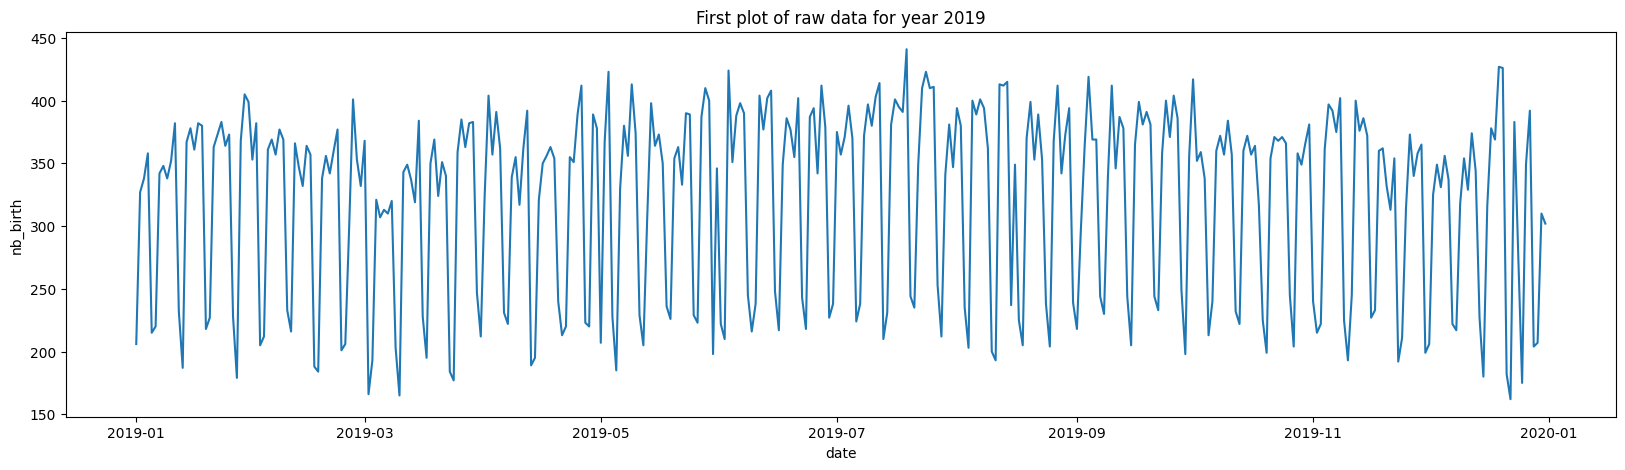

In [3]:
# print raw and smoothed data for 2019
annee = 2019
sub_data = data[data['date'].dt.year == annee].copy()
print(sub_data)

plt.figure(figsize=(20, 5))
plt.title("First plot of raw data for year 2019")
sns.lineplot(data=sub_data, x="date", y="nb_birth")


In [4]:
# get the sundays of 2019 
df_sundays = pd.DataFrame({"date":pd.date_range("2019-01-01", "2019-12-31")})
df_sundays['is_sunday'] = df_sundays['date'].dt.day_of_week==6
df_sundays['value'] = df_sundays.is_sunday.map({True:1000, False:0})
print(df_sundays)

# get public holidays of 2019
public_holidays = pd.DataFrame({"date": ["2019-01-01", "2019-04-22", "2019-05-01", "2019-05-30", "2019-06-10", "2019-07-21", "2019-08-15", "2019-11-01", "2019-11-11", "2019-12-25"]})
public_holidays['date'] = pd.to_datetime(public_holidays['date'])

          date  is_sunday  value
0   2019-01-01      False      0
1   2019-01-02      False      0
2   2019-01-03      False      0
3   2019-01-04      False      0
4   2019-01-05      False      0
..         ...        ...    ...
360 2019-12-27      False      0
361 2019-12-28      False      0
362 2019-12-29       True   1000
363 2019-12-30      False      0
364 2019-12-31      False      0

[365 rows x 3 columns]


Text(0.5, 1.0, 'Fig 1 : Impact of week-ends and public holidays on birth count')

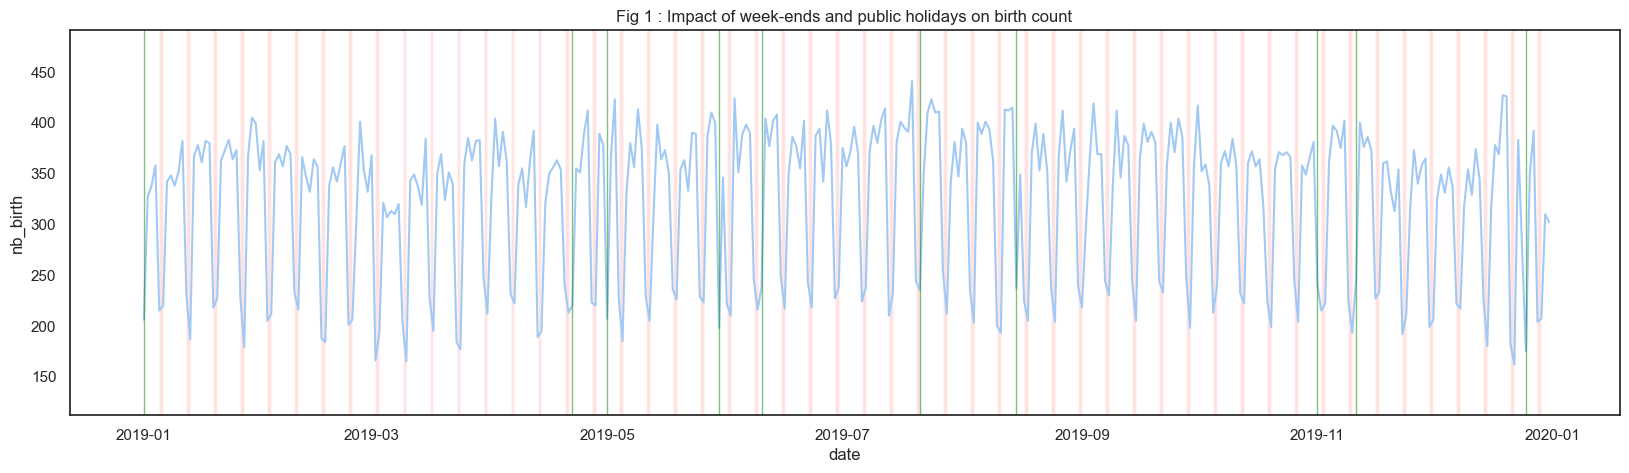

In [5]:
# Validate that drops correspond to week-ends or public holidays

plt.figure(figsize=(20, 5))

sns.set_theme(style="white", palette="pastel")
sns.lineplot(data=sub_data, x="date", y="nb_birth")

# plot vertical line for public holidays
for i in range(len(public_holidays)):
    line = public_holidays.iloc[i]
    date = line["date"]
    plt.axvline(date, color="green", linewidth=1, alpha=0.5)

# plot color bar for sundays (variante with barplot)
plt.bar(
    x=df_sundays["date"],
    height=df_sundays["value"],
    color="r",
    alpha=0.3,
    width=-1,
    align="edge",
)
plt.ylim(min(sub_data["nb_birth"]) - 50, max(sub_data["nb_birth"]) + 50)
plt.title("Fig 1 : Impact of week-ends and public holidays on birth count")

<AxesSubplot: xlabel='date', ylabel='nb_birth'>

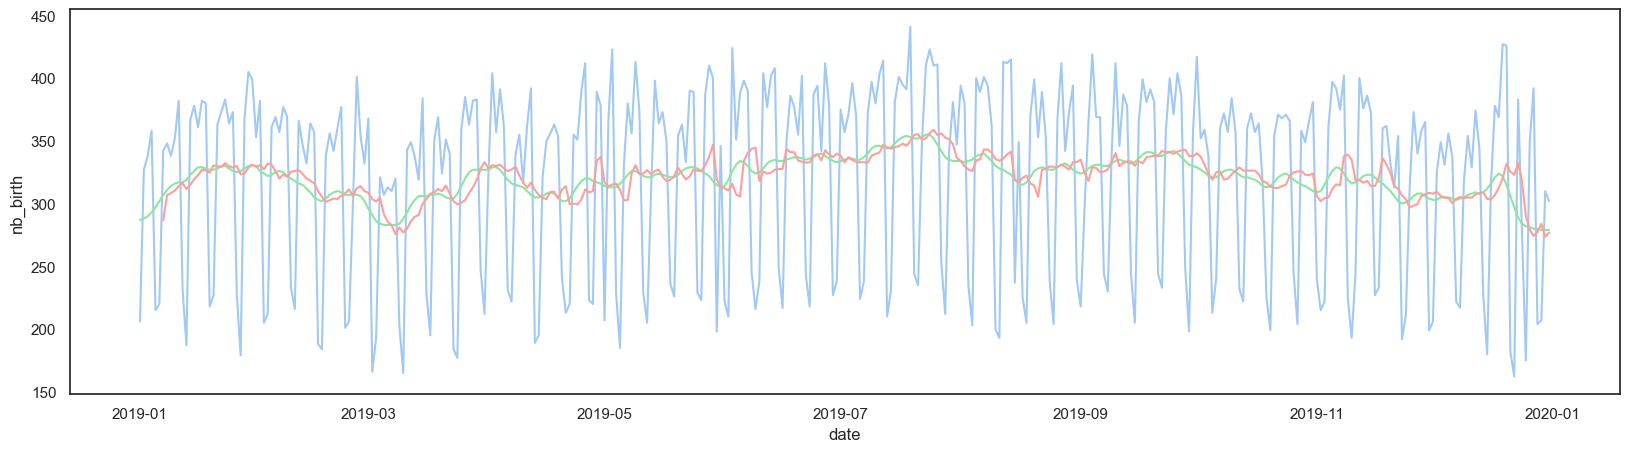

In [6]:
# compute smoothing using gaussian filter 1d de Scipy or rolling mean on 7 days
sigma = 3
sub_data['smooth_gaussian'] = gaussian_filter1d(np.array(sub_data["nb_birth"]), sigma=sigma).round(1)
sub_data["smooth_rolling_mean"] = sub_data.nb_birth.rolling(7).mean().round(1)

plt.figure(figsize=(20, 5))

sns.set_theme(style="white", palette="pastel")
sns.lineplot(data=sub_data, x="date", y="nb_birth")
sns.lineplot(data=sub_data, x="date", y="smooth_gaussian", color="g")
sns.lineplot(data=sub_data, x="date", y="smooth_rolling_mean", color="r")

# choose rolling mean because better reflect of reality : childbirth not given on week-end will be given on the rest of the week 
# -> make sense to average week wise, not only smoothen mathematically

In [7]:
# certaines années sont bissextiles, donc avec un nb differents de jours. 
# on change de preprocessing pour caler toutes les années sur les jours de 2019 (non bissextile)
# -> on passe les jours en colonne

ROLLING_PERIOD = 7
START_YEAR = 2012

df_per_year = pd.DataFrame(
    {"date": pd.date_range("2019-01-01", "2019-12-31").strftime("%d/%m")})

for year in data.date.dt.year.unique():
    if year >= START_YEAR: 
        tmp = data[data.date.dt.year == year].copy()
        tmp["date"] = tmp["date"].dt.strftime("%d/%m")
        # on utilise la date en index (pour se simplifier la vie)
        tmp = (
            tmp.set_index("date")
        )
        # on applique la moyenne glissante
        tmp = (
            tmp.rolling(ROLLING_PERIOD)
            .mean()
        )
        # on arrondie et reset l'index
        tmp = (
            tmp.nb_birth.round(1)
            .rename(year)
            .reset_index()
        )
        # on stock dans df_per_year date par date
        df_per_year = df_per_year.merge(tmp, on="date")

df_per_year["day_of_year"] = np.arange(len(df_per_year))

# on redéfini l'index avec la date et le decompte des jours
df_per_year = (
    df_per_year.set_index(["date", "day_of_year"])
)

# on empile chaque colonne : chaque index a autant de ligne que de colonne. 
# orga de nouvelles colonnes : [Index, année (ancienne colonne), valeurs]
df_per_year = (
    df_per_year.stack()
)

# on sort les dates de l'index et on renomme les colonnes
df_per_year = (
    df_per_year.reset_index().rename(columns={"level_2": "year", 0: "nb_birth_roll"})
)



In [8]:
# plot avec plotly de toutes les années depuis 2010 (interactif)

px.line(
    df_per_year,
    x="day_of_year",
    y="nb_birth_roll",
    color="year",
    range_y=[0, df_per_year.nb_birth_roll.max()],
    hover_data=df_per_year.columns,
)

Text(0.5, 1.0, 'Plot of the cycles of the moon on 2019')

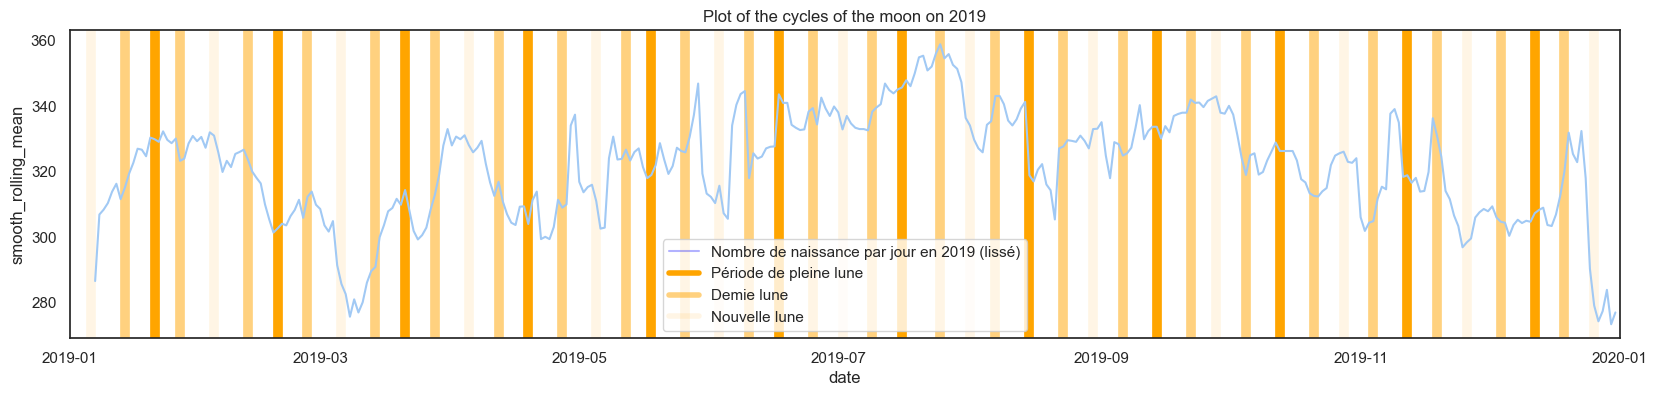

In [9]:
# moon calendar 2019
moon_2019 = pd.read_csv('moon2019.txt')

moon_2019["date"] = pd.to_datetime(moon_2019["date"])
moon_2019.head()

plt.figure(figsize=(20, 4))

for i in range(len(moon_2019)):
    line = moon_2019.iloc[i]
    date = line["date"]
    type = line["moon"]
    if type == 1:
        plt.axvline(date, color="orange", linewidth=7, alpha=1)
    elif type == 0.5:
        plt.axvline(date, color="orange", linewidth=7, alpha=0.5)
    elif type == 0:
        plt.axvline(date, color="orange", linewidth=7, alpha=0.1)

sns.lineplot(data=sub_data, x="date", y="smooth_rolling_mean", color="b")

plt.xlim(pd.to_datetime("2019-01-01"), pd.to_datetime("2020-01-01"))

plt.legend(
    handles=[
        mlines.Line2D(
            [],
            [],
            color="blue",
            alpha=0.3,
            markersize=15,
            label="Nombre de naissance par jour en 2019 (lissé)",
        ),
        mlines.Line2D(
            [],
            [],
            color="orange",
            alpha=1,
            linewidth=4,
            markersize=15,
            label="Période de pleine lune",
        ),
        mlines.Line2D(
            [],
            [],
            color="orange",
            alpha=0.5,
            linewidth=4,
            markersize=15,
            label="Demie lune"
        ),
        mlines.Line2D(
            [],
            [],
            color="orange",
            alpha=0.1,
            linewidth=4,
            markersize=15,
            label="Nouvelle lune",
        ),
    ]
)

plt.title("Plot of the cycles of the moon on 2019")


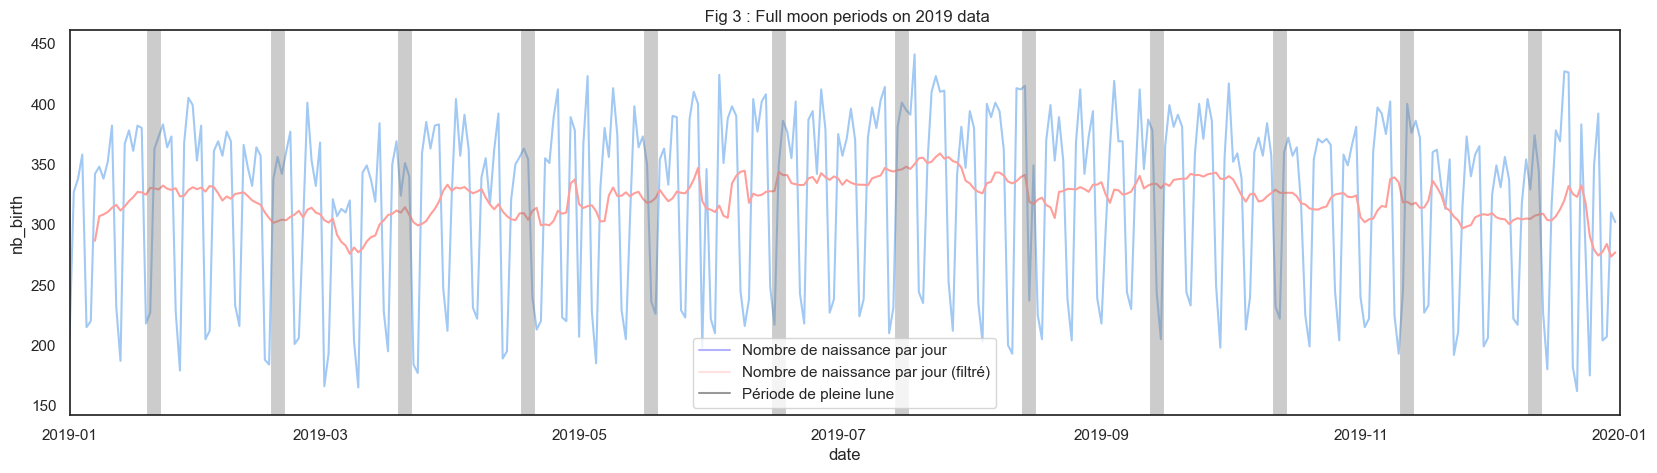

In [10]:
# final plot : 2019 filtered and unfiltered, sundays, full moons
import matplotlib.lines as mlines

plt.figure(figsize=(20, 5))

sns.set_theme(style="white", palette="pastel")
sns.lineplot(data=sub_data, x="date", y="nb_birth")
sns.lineplot(data=sub_data, x="date", y="smooth_rolling_mean", color="r")

# plot periods of full moon
for i in range(len(moon_2019)):
    line = moon_2019.iloc[i]
    date = line["date"]
    type = line["moon"]
    if type == 1:
        plt.axvline(date, color="grey", linewidth=10, alpha=0.4)


plt.ylim(min(sub_data["nb_birth"]) - 20, max(sub_data["nb_birth"]) + 20)
plt.xlim(pd.to_datetime("2019-01-01"), pd.to_datetime("2020-01-01"))

plt.title(
    " Fig 3 : Full moon periods on 2019 data"
)

# plot legend
plt.legend(
    handles=[
        mlines.Line2D(
            [],
            [],
            color="blue",
            alpha=0.3,
            markersize=15,
            label="Nombre de naissance par jour",
        ),
        mlines.Line2D(
            [],
            [],
            color="r",
            alpha=0.3,
            markersize=15,
            label="Nombre de naissance par jour (filtré)",
        ),
        mlines.Line2D(
            [],
            [],
            color="black",
            alpha=0.4,
            markersize=15,
            label="Période de pleine lune",
        ),
    ]
)

In [11]:
## Analyse statistique des jours de pleine lune VS jours hors pleine lune
# on considère une période de pleine lune comme un jour avant et un jour après la pleine lune officielle (3 jours)

In [12]:
# creation des dataframe respectifs
df_moon_value = moon_2019[moon_2019['moon']==1]

df_moon_value = df_moon_value.date.apply(
                                       lambda x : pd.Series(
                                                            pd.date_range(
                                                                        x - pd.Timedelta(days=1),
                                                                        x + pd.Timedelta(days=1)
)))

df_moon_value = df_moon_value.stack().drop_duplicates().reset_index(level=[0,1], drop=True).to_frame(name='date')
df_moon_value = df_moon_value.merge(sub_data, on='date')
df_moon_value['type'] = ['moon'] * len(df_moon_value)

df_normal_value = pd.date_range('2019-01-01', '2019-12-31').to_frame(name='date')

mask = []
for day in pd.date_range('2019-01-01', '2019-12-31'): 
    if (df_moon_value.date == day).any():
        mask.append(False)
    else : 
        mask.append(True)

df_normal_value = df_normal_value[mask].reset_index(drop=True)
df_normal_value = df_normal_value.merge(sub_data, on='date')
df_normal_value['type'] = ['regular'] * len(df_normal_value)

df_stats = pd.concat([df_normal_value, df_moon_value]).reset_index()

In [13]:
from scipy.stats import t, ttest_1samp

ALPHA = 0.05

# calcul des moyennes et IC des deux groupes
print('### Full moon period')
print(df_moon_value.describe())

intervalle_t_student_moon = ttest_1samp(a=df_moon_value['smooth_rolling_mean'].dropna(), popmean=0.5) # popmean n'a pas d'influence sur les IC
print(f'Intervalle de confiance sur la moyenne : {intervalle_t_student_moon.confidence_interval(confidence_level=1-ALPHA)}\n')

print('### Regular moon period')
print(df_normal_value.describe())

intervalle_t_student_reg = ttest_1samp(a=df_normal_value['smooth_rolling_mean'].dropna(), popmean=0.5) # popmean n'a pas d'influence sur les IC
print(intervalle_t_student_reg)
print(f'Intervalle de confiance sur la moyenne : {intervalle_t_student_reg.confidence_interval(confidence_level=1-ALPHA)}\n')

# -> très peu de difference sur les moyennes de la série rolling_mean  

### Full moon period
         nb_birth  smooth_gaussian  smooth_rolling_mean
count   36.000000        36.000000            36.000000
mean   322.833333       321.138889           322.086111
std     65.729098        13.642691            13.661252
min    205.000000       302.000000           301.400000
25%    243.000000       308.000000           309.775000
50%    349.000000       321.000000           318.950000
75%    373.250000       330.500000           330.175000
max    415.000000       353.000000           347.900000
Intervalle de confiance sur la moyenne : ConfidenceInterval(low=317.4638085024883, high=326.7084137197339)

### Regular moon period
         nb_birth  smooth_gaussian  smooth_rolling_mean
count  329.000000       329.000000           323.000000
mean   320.610942       320.246201           321.395046
std     75.974286        15.502661            16.316540
min    162.000000       279.000000           273.400000
25%    233.000000       310.000000           310.200000
50%    

In [14]:
# boxplot of both periods

df_boxplot = pd.DataFrame({'fullmoon': df_moon_value['smooth_rolling_mean'], 'regular':df_normal_value['smooth_rolling_mean']})
df_boxplot = df_boxplot.stack().reset_index().drop(columns='level_0').rename(columns={'level_1':'period', 0:'nb_birth_roll'})

px.box(df_boxplot, x='period', y='nb_birth_roll', points='all')


In [15]:
# on veut observer la répartition des valeurs (histogramme)
fig_moon = px.histogram(df_moon_value, x='smooth_rolling_mean', nbins=10, 
                        title='Repartition of number of birth on full moon period')
fig_moon.update_layout(bargap=0.1)
fig_moon.show()

fig_normal = px.histogram(df_normal_value, x='smooth_rolling_mean', nbins=20, 
                          title='Repartition of number of birth out of full moon period')
fig_normal.update_layout(bargap=0.1)
fig_normal.show()

# -> la répartition de pleine lune corrspond à un echantillon hors pleine lune

In [16]:
# A/B testing : which period makes more baby ?
# -> real difference or random luck
# 
# Hypthesis tests : are differences between periods significant ? 
# Null hypo = no difference
# alternative hypo = significantly more babies on full moon
# 
# We use a permutation test to show if difference is signficant or not

In [17]:
# permutation test 
import random 

def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

Observed difference of means : 0.691064671482593

Percentage of times random permutation mean exceed obeserved mean (p-value) : 38.9 %


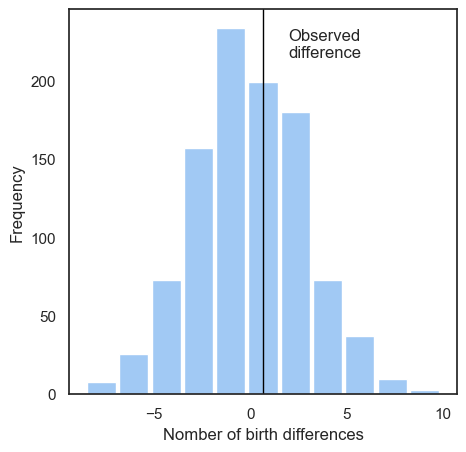

In [18]:
# we work on the rolling mean values of both periods
mean_moon = df_moon_value.smooth_rolling_mean.mean()
mean_regular = df_normal_value.smooth_rolling_mean.mean()
print(f'Observed difference of means : {mean_moon - mean_regular}\n')

nA = len(df_stats.loc[df_stats.type == 'moon'])
nB = len(df_stats.loc[df_stats.type == 'regular'])
perm_diffs = [perm_fun(df_stats.smooth_rolling_mean, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5,5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=mean_moon-mean_regular, color='black', lw=1)
ax.text(2,215, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Nomber of birth differences')
ax.set_ylabel('Frequency')

# p-value represent number of times we could expect the random model to have more extrem results than observed repartition (by chance)
# here we have larger differences of child birth in 40% of time, far from 5% alpha
print(f'Percentage of times random permutation mean exceed obeserved mean (p-value) : {np.mean(perm_diffs > mean_moon - mean_regular)*100} %')


# We don't reach level of significancy : random permutation exceed observation more than 5% of the time
# coherent with the small difference between means of the two sets

In [19]:
# calculating p-value with sci-py t-test (approximation of permutation test with distribution)
res = stats.ttest_ind(df_moon_value.smooth_rolling_mean,
                      df_normal_value.smooth_rolling_mean.dropna(),
                      equal_var=False) # when 2 population are not same size or same variance

print(f'p-value for single sided test : {res.pvalue / 2:.4f}')

p-value for single sided test : 0.3896
